# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [28]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [29]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force.

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions.

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero.

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$,

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$,
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional.

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$.

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$,
with the error indicator

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$,

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible.

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

In [30]:
def setup(xc, yc):
  # Define rectangular domain
  L = 4
  H = 4

  # Define circle
  #xc = 0.5
 # yc = 0.5*H
  rc = 0.2


  # Generate mesh (examples with and without a hole in the mesh)
  resolution = 32
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # Local mesh refinement (specified by a cell marker)
  init_no_levels = 0
  for i in range(0,init_no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(0.5, 0.5)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

 # plt.figure()
 # plot(mesh)
 # plt.show()

  return mesh, H, L

In [31]:
def solver(mesh, psi_1, psi_2, psi_3, H, L):

  #### define FEM approx spaces ####

  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W)

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)


  #### boundary conditions ####

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())


  ## define and solve variational problem
  #### solve problem ####

  # Set boundary penalty parameter gamma
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
  psi1 = Expression((psi_1[0],psi_1[1]), element = V.ufl_element())
  psi2 = Expression(psi_2, element = Q.ufl_element())
  phi3 = Expression((psi_3[0],psi_3[1]), element = V.ufl_element())

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system
  solve(res == 0, w)

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system
  solve(res_a == 0, wa)

  return u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma



# **Results**

**Visualize solution and export files**

In [32]:
def visualization(u, p, phi, theta, V, Q):
  !rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn


  # Plot solution

  # primal
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plot(u_fcn, title="Velocity")

  plt.subplot(1, 2, 2)
  plot(p_fcn, title="Pressure")
  plt.show()

  # adjoint
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plot(phi_fcn, title="Adjoint velocity")

  plt.subplot(1, 2, 2)
  plot(theta_fcn, title="Adjoint pressure")
  plt.show()

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

**Compute error indicators**

In [33]:
def error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh):

  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()]
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)

  #plt.figure()
  #plot(mesh)
  #plt.show()

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)
  s = 'Total error = ' + repr(tot_err)
  #print(s)
  return mesh, s, tot_err

**Solver function**

rm: cannot remove 'results-NS/*': No such file or directory


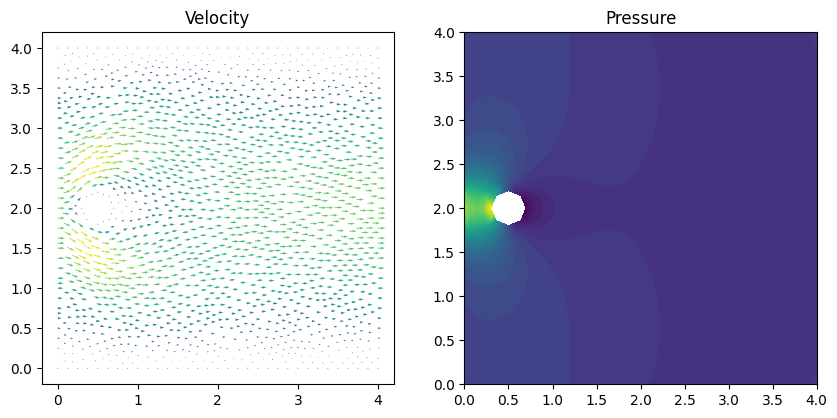

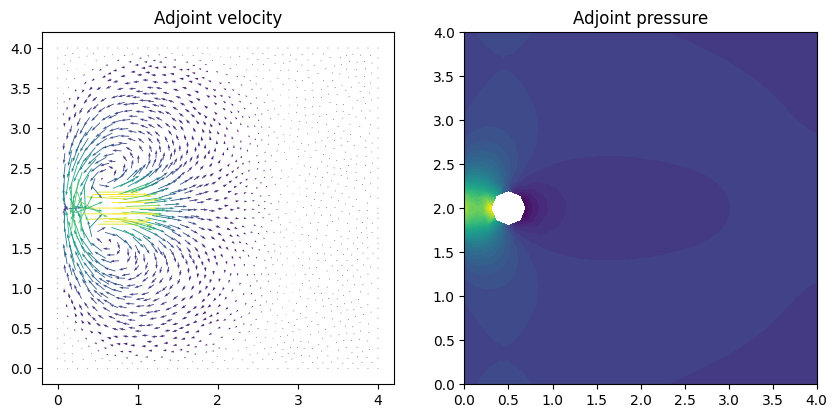

In [34]:
mesh, H, L = setup(0.5, 2)

psi1 = ["0.0", "0.0"]
psi2 = "0.0"
psi3 = ["1.0", "0.0"]

u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma = solver(mesh, psi1, psi2, psi3, H, L)


mesh2, s, tot_err = error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh)


visualization(u, p, phi, theta, V, Q)


# **Moving center of circle over the domain**

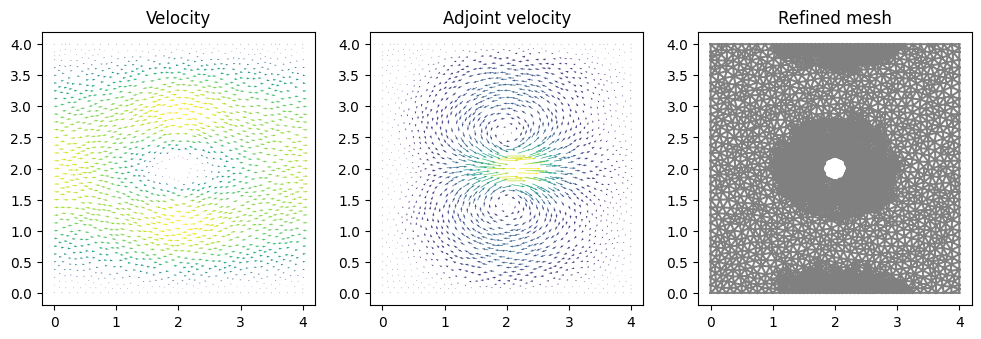

Total error = 0.005544566319844384


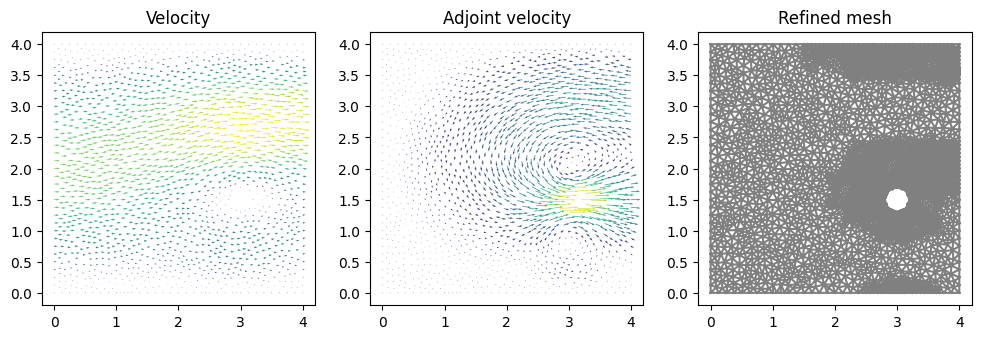

Total error = 0.002931098592610456


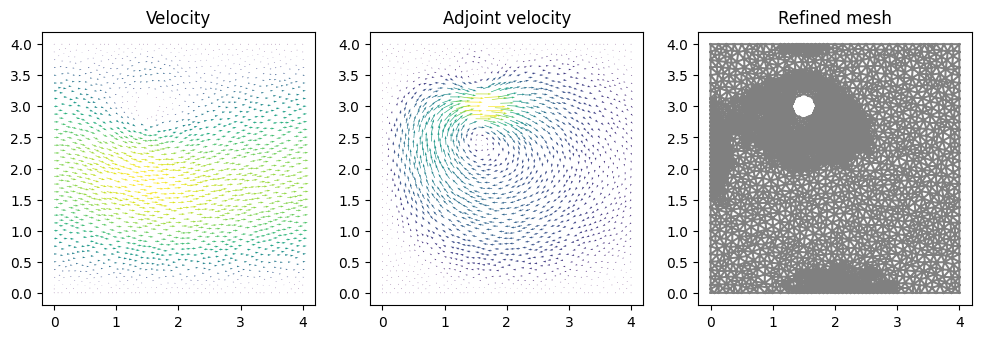

Total error = 0.003259317935650486


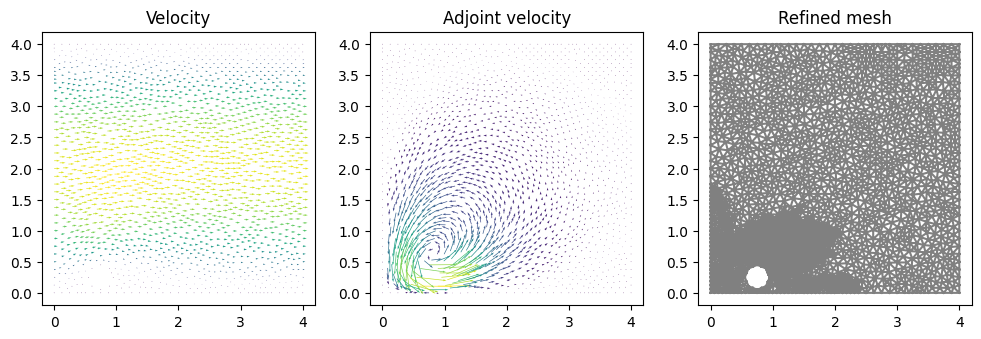

Total error = 0.016418323019590227


In [35]:
psi1 = ["0.0", "0.0"]
psi2 = "0.0"
psi3 = ["1.0", "0.0"]

xc_s = [2, 3, 1.5, 0.75]
yc_s = [2, 1.5, 3, 0.25]

phi_s = []
theta_s = []
u_s = []
meshes = []
errors = []

for i in range(4):
  mesh, H, L = setup(xc_s[i], yc_s[i])
  u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma = solver(mesh, psi1, psi2, psi3, H, L)
  phi_s.append(phi)
  u_s.append(u)
  theta_s.append(theta)
  mesh_, s, tot_err = error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh)
  meshes.append(mesh_)
  errors.append(s)


# plotting velocity, adjoint velocity, refined mesh
for j in range(4):
  plt.figure(figsize=(12,12))
  plt.subplot(1, 3, 1)
  plot(u_s[j], title="Velocity")

  plt.subplot(1, 3, 2)
  plot(phi_s[j], title="Adjoint velocity")

  plt.subplot(1, 3, 3)
  plot(meshes[j], title="Refined mesh")
  plt.show()
  print(errors[j])


#error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh)
#visualization(u, p, phi, theta, V, Q)

**Describe how mesh refinement and adjoint solution changes**

The adjoint problem defined here is based on the drag force around the cylinder. We can see that the adjoint velocity is large where the cylinder is. The mesh refinement is done where the adjoint velocity is large, as well as on some boundaries close to or in vertical alignment with the cylinder.


# **The functional**
In this assignment, we change the data in the adjoint problem by adjusting the parameters $\psi_1$, $\psi_2$ and $\psi_3$ to see changes in the adjoint solution and the local mesh refinement. Some different cylinder placements were done to see if results changed.

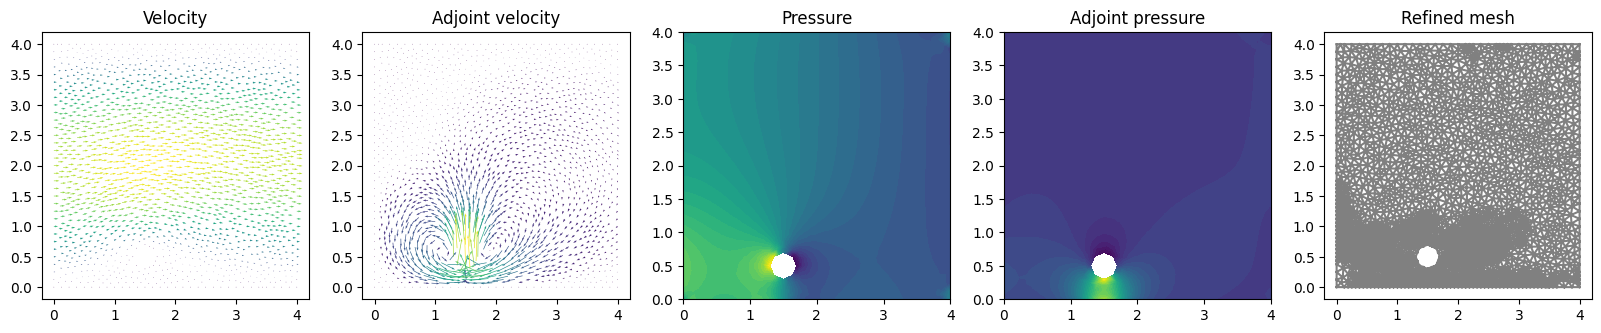

Total error = -0.00035215516691221397


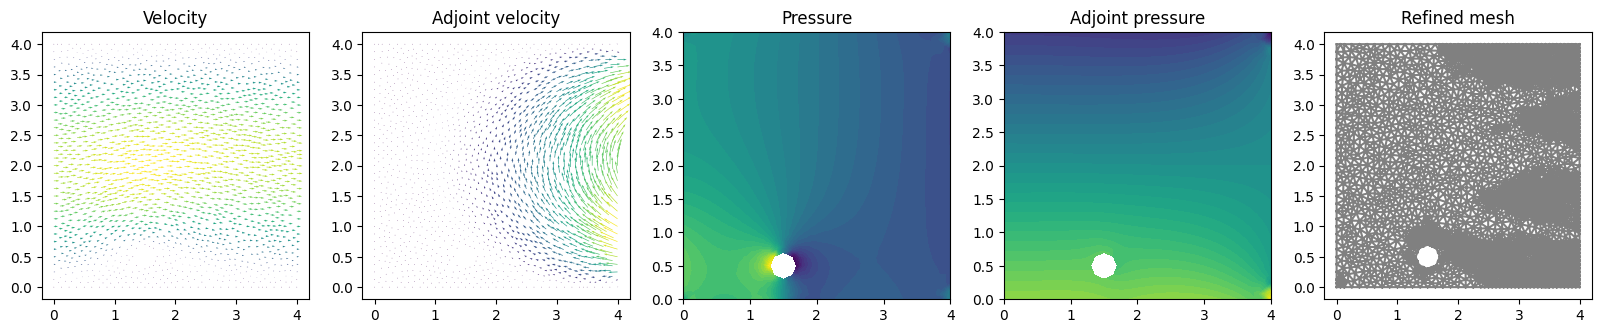

Total error = 0.0004110334087952671


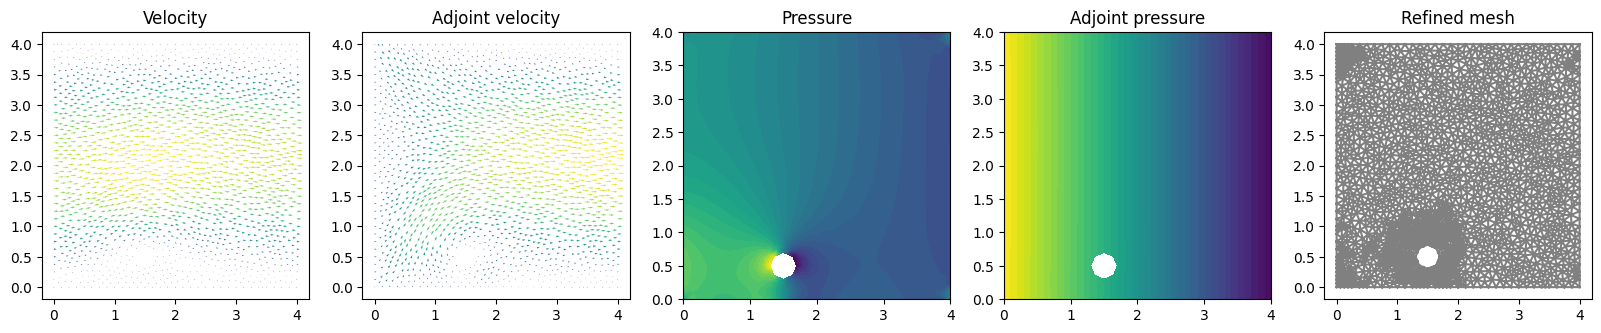

Total error = 9.33572318972873e-05


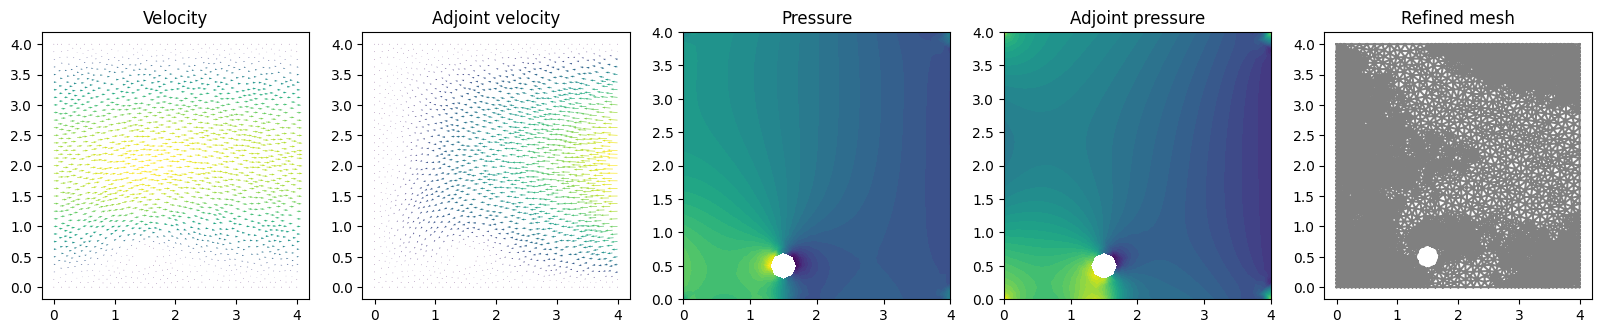

Total error = -0.011852296778280591


In [36]:


xc = 1.5
yc = 0.5

# values to keep
phi_s = []
theta_s = []
u_s = []
p_s = []
meshes = []
errors = []

# first round = lift force
# second round = integrate in u_y, third round = integrate in u_x,
# fourth round = integrate in pressure

psi1 = [["0.0", "0.0"], ["0.0", "1.0"], ["1.0", "0.0"], ["0.0", "0.0"]]
psi2 = [ "0.0", "0.0", "0.0", "1.0"]
psi3 = [["0.0", "1.0"], ["0.0", "0.0"], ["0.0", "0.0"], ["0.0", "0.0"]]

for i in range(4):
  mesh, H, L = setup(xc, yc)
  u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma = solver(mesh, psi1[i], psi2[i], psi3[i], H, L)
  phi_s.append(phi)
  u_s.append(u)
  p_s.append(p)
  theta_s.append(theta)
  mesh_, s, tot_err = error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh)
  meshes.append(mesh_)
  errors.append(s)


# plotting velocity, adjoint velocity, refined mesh
for j in range(4):
  plt.figure(figsize=(20,20))
  plt.subplot(1, 5, 1)
  plot(u_s[j], title="Velocity")

  plt.subplot(1, 5, 2)
  plot(phi_s[j], title="Adjoint velocity")

  plt.subplot(1, 5, 3)
  plot(p_s[j], title="Pressure")

  plt.subplot(1, 5, 4)
  plot(theta_s[j], title="Adjoint pressure")

  plt.subplot(1, 5, 5)
  plot(meshes[j], title="Refined mesh")
  plt.show()
  print(errors[j])




Looking at these different plots, we can see that:

Plot 1: Lift force. The adjoint solution is based on the lift force, and the mesh is refined where the lift force is largest as well as the closest boundaries to the large lift force.

Plot 2: Integration in $u_y$. Here the mesh is refined where the mean velocity in y is the largest, as well as around the cylinder. The cylinder refinement is likely due to the sharp boundaries, making the error larger in this area.

Plot 3: Integration in $u_x$. Here the refinement is done around the cylinder and its sharp boundaries, which is different from the three earlier cases (including drag force from before).

Plot 4: Adjoint pressure = 1. The mesh refinement is done where the adjoint pressure is larger, which happens in the upstream part of domain around cylinder and corners, as well as in the corners downstream in the domain.

# **Adaptive Algorithm**

In this assignment, we are extending the algorithm into an adaptive method for recursive local mesh refinement based on the error indicator from the adjoint solution. This means: we will compute a solution and its error based on adjoint solution, compute a mesh refinement and solve again on the new mesh. This is repeated until some tolerance of the total error is met.

In the first case, the adjoint solution is based on the drag force and the cylinder is placed in the center of the domain, i.e. (2, 2). This was chosen due to runtime error in other configurations, probably because the solver could not converge to a solution for certain meshes. For this configuration, the tolerance of total error was set to $TOL = 10^{-3}$.

Looking at the adjoint solution in terms of velocity in x (integrating in $u_x$), a lower tolerance could be used, $TOL = 10^{-5}$, and the cylinder's center was set to (1, 3).

How the domain is setup and what adjoint solution is looked at affects the results and how much of a refinement can be done, as well as where the refinement is done as seen in previous assignments. The solution converges faster for certain configurations.


100
0.005544566319844384
0.0028315508495896885
0.0011133787421055016


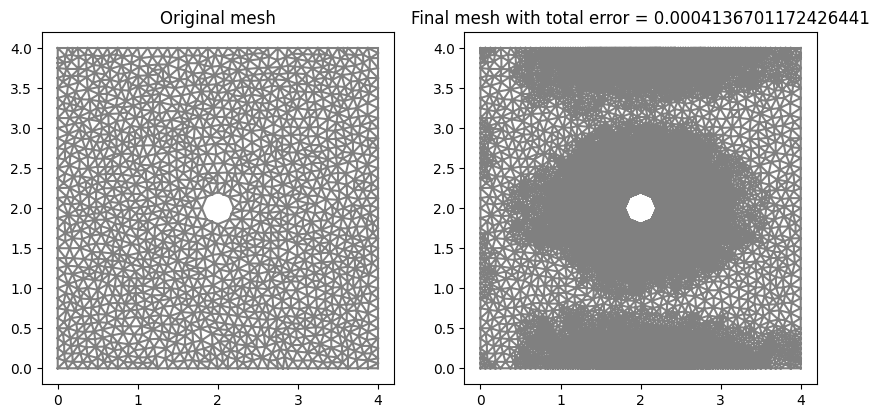

100
5.091448212476628e-05


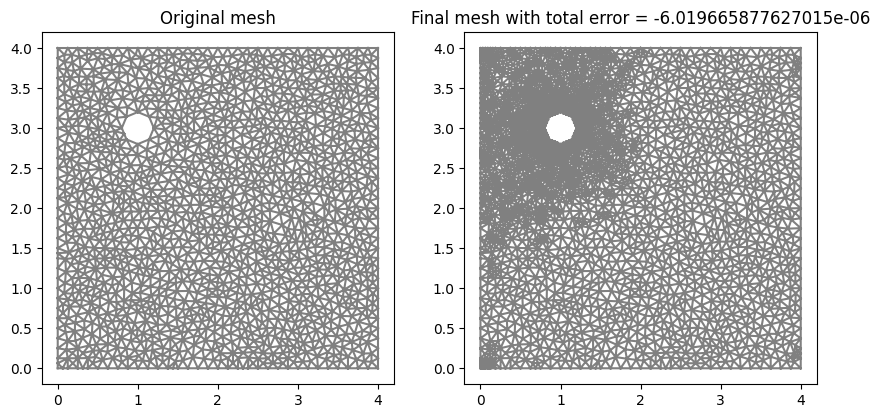

In [37]:
#### setup of domain, initial mesh and psi-parameters for drag force
xc = 2
yc = 2
mesh, H, L = setup(xc, yc)
psi1 = ["0.0", "0.0"]
psi2 = "0.0"
psi3 = ["1.0", "0.0"]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plot(mesh, title="Original mesh")

# solver iteration
# set error tolerance
TOL = 1e-3
tot_err = 100
mesh_ = mesh

while abs(tot_err) > TOL:
  print(abs(tot_err))
  u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma = solver(mesh_, psi1, psi2, psi3, H, L)
  mesh_, s, tot_err = error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh_)

plt.subplot(1,2,2)
plot(mesh_, title=f"Final mesh with total error = {tot_err}")
plt.show()


#### setup of domain, initial mesh and psi-parameters for velocity in x
xc = 1
yc = 3
mesh, H, L = setup(xc, yc)
psi1 = ["1.0", "0.0"]
psi2 = "0.0"
psi3 = ["0.0", "0.0"]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plot(mesh, title="Original mesh")


# solver iteration
# set error tolerance
TOL = 1e-5
tot_err = 100
mesh_ = mesh

while abs(tot_err) > TOL:
  print(abs(tot_err))
  u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma = solver(mesh_, psi1, psi2, psi3, H, L)
  mesh_, s, tot_err = error_indicators(u, p, V, Q, W, phi, theta, f, uin, ib, ob, wb, bb, gamma, mesh_)


plt.subplot(1,2,2)
plot(mesh_, title=f"Final mesh with total error = {tot_err}")
plt.show()



Looking at the plots and the results from the earlier assignment, in the drag force solution we can also see the refinement happening where the adjoint velocity is large and close boundaries. For the velocity in x, we can see that the refinement is happening around the cylinder as well, probably due to its sharp boundaries making the error larger in these areas.

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.